<a href="https://colab.research.google.com/github/hardyjeremy98/FloodNet/blob/main/FloodNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


---

In [ ]:
# Import PyTorch
import torch
import torch.nn as nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


---
# Getting data

In [ ]:
data_folder = r'/content/gdrive/MyDrive/FloodNet-Supervised_v1.0'
train_folder = r'/content/gdrive/MyDrive/FloodNet-Supervised_v1.0/train'

train_image_folder = r'/content/gdrive/MyDrive/FloodNet-Supervised_v1.0/train/train-org-img'
train_mask_folder = r'/content/gdrive/MyDrive/FloodNet-Supervised_v1.0/train/train-label-img'

In [ ]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files/images in {dirpath}")

In [ ]:
walk_through_dir(data_folder)

There are 3 directories and 1 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0
There are 2 directories and 0 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/val
There are 0 directories and 450 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/val/val-label-img
There are 0 directories and 450 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/val/val-org-img
There are 2 directories and 0 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/test
There are 0 directories and 448 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/test/test-label-img
There are 0 directories and 448 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/test/test-org-img
There are 2 directories and 0 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/train
There are 0 directories and 1445 files/images in /content/gdrive/MyDrive/FloodNet-Supervised_v1.0/train/train-label-img
There are 0 directories a

In [ ]:
# prompt: Write code for a function that will plot a random image from the folder given

import torchvision.io as tv
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import os
import random

def plot_random_image(im_folder, label_folder):
  """
  This function plots a random image from the given folder.

  Args:
    folder: The folder path containing the images.
  """

  # Get a list of all files in the folder
  files = os.listdir(im_folder)

  # Choose a random image from the list
  random_image_index = random.randint(0, len(files) - 1)
  random_image_name = files[random_image_index][:-4]
  random_image_path = os.path.join(im_folder, random_image_name + '.jpg')

  random_label_path = os.path.join(label_folder, random_image_name + '_lab.png')

  # Load the image using matplotlib
  img = plt.imread(random_image_path)
  label = plt.imread(random_label_path)

  # OR
  # Load the image using pytorch
  # img = tv.read_image(random_image_path)
  # label = tv.read_image(random_label_path)
  # img = img.permute(1, 2, 0)
  # label = label.permute(1, 2, 0)

  # Display the image
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  plt.imshow(label)
  plt.axis('off')
  plt.show()

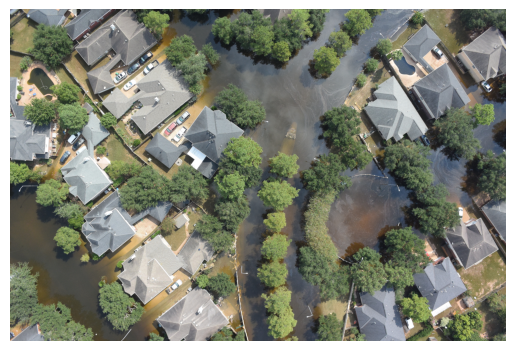

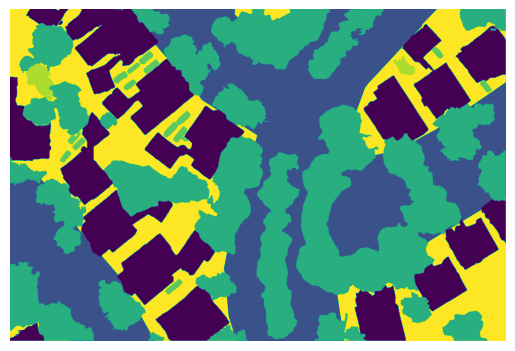

In [ ]:
plot_random_image(train_image_folder, train_mask_folder)

---
# Creating data loaders

In [ ]:
from torchvision.transforms import v2

data_transformer = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(p=1),
    v2.RandomRotation(30),
    v2.ToTensor()
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
from torch.utils.data.dataset import Dataset
from PIL import Image

class floodDataset(Dataset):
  def __init__(self, img_path, mask_path, transform = None):
    self.image_paths = sorted([os.path.join(img_path, path) for path in os.listdir(img_path)])
    self.mask_paths = sorted([os.path.join(mask_path, path) for path in os.listdir(mask_path)])

    self.transform = transform

  def load_image_pair(self, index):
    image = self.image_paths[index]
    mask = self.mask_paths[index]
    return Image.open(image), Image.open(mask)

  def __getitem__(self, index):
    img, mask = self.load_image_pair(index)

    if self.transform:
      return self.transform(img), self.transform(mask)

  def __len__(self):
    return len(self.image_paths)

In [ ]:
train_dataset = floodDataset(train_image_folder, train_mask_folder, data_transformer)

In [ ]:
print(len(train_dataset))

1445


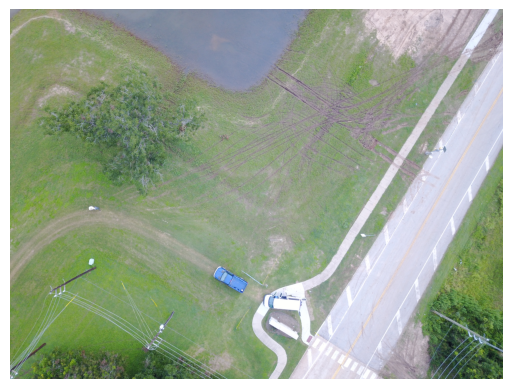

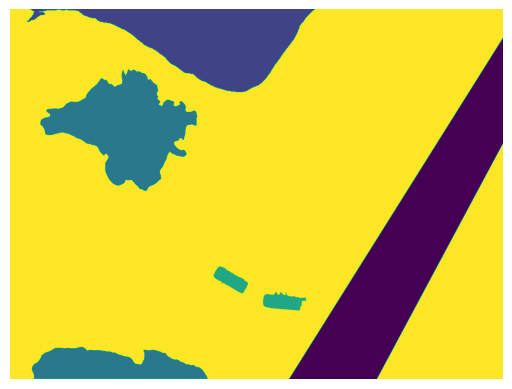

In [ ]:
image, mask = train_dataset.load_image_pair(100)

plt.imshow(image)
plt.axis('off')
plt.show()

plt.imshow(mask)
plt.axis('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

# test_dataloader_custom = DataLoader(dataset=test_dataset, # use custom created test Dataset
#                                     batch_size=1,
#                                     num_workers=0,
#                                     shuffle=False) # don't usually need to shuffle testing data

train_dataloader

In [ ]:
for img, mask in train_dataloader:

  print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
  break

Image shape: torch.Size([16, 3, 128, 128]) -> [batch_size, color_channels, height, width]


---
# Create UNet

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    return self.double_conv(x)

In [ ]:
class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = DoubleConv(in_channels, out_channels)
    self.down = nn.MaxPool2d(2)

  def forward(self, x):
    skip_con = self.double_conv(x)
    down = self.down(skip_con)
    return (down, skip_con)

In [ ]:
class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
    self.double_conv = DoubleConv(in_channels, out_channels)

  def forward(self, x, skip_con):
    x = self.up(x)
    x = torch.cat([x, skip_con], dim=1)
    x = self.double_conv(x)
    return x

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.down1 = Down(in_channels, 64)
    self.down2 = Down(64, 128)
    self.down3 = Down(128, 256)
    self.down4 = Down(256, 512)

    self.bottleneck = DoubleConv(512, 1024)

    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)

    self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

  def forward(self, x):
    down_1, skip_con1 = self.down1(x)
    down_2, skip_con2 = self.down2(down_1)
    down_3, skip_con3 = self.down3(down_2)
    down_4, skip_con4 = self.down4(down_3)

    b = self.bottleneck(down_4)

    up_1 = self.up1(b, skip_con4)
    up_2 = self.up2(up_1, skip_con3)
    up_3 = self.up3(up_2, skip_con2)
    up_4 = self.up4(up_3, skip_con1)

    out = self.out(up_4)

    return out

---
Test UNET

In [ ]:
model = UNet(3, 1)

In [ ]:
img_batch, mask_batch = next(iter(train_dataloader))

img_single, mask_single = img_batch[0].unsqueeze(dim=0), mask_batch[0].unsqueeze(dim=0)
print(f"Single image shape: {img_single.shape}\n")
print(f"Single mask shape: {mask_single.shape}\n")

Single image shape: torch.Size([1, 3, 128, 128])

Single mask shape: torch.Size([1, 1, 128, 128])



In [ ]:
output = model(img_single)
print(output)

tensor([[[[0.0214, 0.0228, 0.0222,  ..., 0.0223, 0.0226, 0.0204],
          [0.0197, 0.0207, 0.0188,  ..., 0.0188, 0.0206, 0.0165],
          [0.0189, 0.0189, 0.0168,  ..., 0.0163, 0.0181, 0.0160],
          ...,
          [0.0192, 0.0198, 0.0170,  ..., 0.0164, 0.0180, 0.0162],
          [0.0195, 0.0187, 0.0170,  ..., 0.0160, 0.0176, 0.0161],
          [0.0184, 0.0167, 0.0158,  ..., 0.0160, 0.0164, 0.0166]]]],
       grad_fn=<ConvolutionBackward0>)


In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─Down: 1-1                              [1, 64, 64, 64]           --
│    └─DoubleConv: 2-1                   [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         38,720
│    └─MaxPool2d: 2-2                    [1, 64, 64, 64]           --
├─Down: 1-2                              [1, 128, 32, 32]          --
│    └─DoubleConv: 2-3                   [1, 128, 64, 64]          --
│    │    └─Sequential: 3-2              [1, 128, 64, 64]          221,440
│    └─MaxPool2d: 2-4                    [1, 128, 32, 32]          --
├─Down: 1-3                              [1, 256, 16, 16]          --
│    └─DoubleConv: 2-5                   [1, 256, 32, 32]          --
│    │    └─Sequential: 3-3              [1, 256, 32, 32]          885,248
│    └─MaxPool2d: 2-6                    [1, 256, 16, 16]          --
├

In [ ]:
from tqdm.auto import tqdm

def train_step(model, dataloader, loss_fn, optimizer):
  # Put model in training mode
  model.train()

  # Initiate train loss/accuracy
  train_loss, train_acc = 0, 0

  for n_batch, img_mask in enumerate(tqdm(dataloader)):

    img = img_mask[0].to(device)
    mask = img_mask[1].to(device)

    # Forward pass
    mask_pred = model(img)

    # Calculate and accumulate loss
    loss = loss_fn(mask_pred, mask)
    train_loss += loss.item()

    # Reset optimizer to zero gradient
    optimizer.zero_grad()

    # Back prop
    loss.backward()

    # Optimizer step (change params)
    optimizer.step()

    mask_pred_class = torch.argmax(torch.softmax(mask_pred, dim=1), dim=1)
    train_acc += (mask_pred_class == mask).sum().item()/len(mask_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
from timeit import default_timer as timer

def train(model, dataloader, loss_fn, optimizer, epochs=5):
  start_time = timer()

  results = {"train_loss": [],
             "train_acc": []}

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model, dataloader, loss_fn, optimizer)

    print(
        f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

  end_time = timer()

  print(f"Total training time: {(end_time - start_time):.3f} seconds")
  return results

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [ ]:
train(model, train_dataloader, loss_fn, optimizer, epochs=5)

  0%|          | 0/91 [00:00<?, ?it/s]